## Install Packages

In [ ]:
!python -m spacy download en_core_web_sm
!pip install openai
!pip install gradio
!pip install -U sentence-transformers rank_bm25

2023-09-02 22:31:32.402859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Import libraries

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import os
import time
import json
import re
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from collections import Counter
from heapq import nlargest
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from openai.embeddings_utils import get_embedding, cosine_similarity
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read Miami hotel data

In [ ]:
miami_raw_data =  pd.read_csv('https://raw.githubusercontent.com/hamzafarooq/maven-mlsystem-design-cohort-1/main/data/miami_hotels.csv')

In [ ]:
miami_raw_data.shape

(2511, 27)

## Exploratory Data Analysis

In [ ]:
miami_raw_data.columns

Index(['id', 'type', 'name', 'image', 'awards', 'rankingPosition',
       'priceLevel', 'priceRange', 'category', 'rating', 'hotelClass',
       'hotelClassAttribution', 'phone', 'address', 'email', 'amenities',
       'numberOfRooms', 'prices', 'latitude', 'longitude', 'webUrl', 'website',
       'rankingString', 'rankingDenominator', 'numberOfReviews', 'review',
       'title'],
      dtype='object')

In [ ]:
miami_raw_data.name.value_counts()

Faena Miami Beach                          45
Setai Hotel Miami                          45
Best Western Plus Atlantic Beach Resort    45
1 Hotel South Beach                        45
Nobu Hotel Miami Beach                     45
                                           ..
The Julia Hotel, Miami Beach                6
Beach Park Hotel                            4
Bikini Lodge                                4
Baltic Hotel                                2
Sherry Frontenac Hotel                      1
Name: name, Length: 65, dtype: int64

### Drop duplicate records

In [ ]:
miami_data = miami_raw_data.drop_duplicates()

In [ ]:
miami_data.shape

(2511, 27)

In [ ]:
miami_data.name.value_counts()

Faena Miami Beach                          45
Setai Hotel Miami                          45
Best Western Plus Atlantic Beach Resort    45
1 Hotel South Beach                        45
Nobu Hotel Miami Beach                     45
                                           ..
The Julia Hotel, Miami Beach                6
Beach Park Hotel                            4
Bikini Lodge                                4
Baltic Hotel                                2
Sherry Frontenac Hotel                      1
Name: name, Length: 65, dtype: int64

### 5 point summary

In [ ]:
miami_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2511.0,NaN,NaN,NaN,4274959.788132,6514487.892149,85050.0,217415.0,1011427.0,5888192.0,23526747.0
type,2511,1,HOTEL,2511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,2511,65,Faena Miami Beach,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image,2511,65,https://media-cdn.tripadvisor.com/media/photo-...,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
awards,2511,1,[],2511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rankingPosition,2511.0,NaN,NaN,NaN,49.47949,44.693434,1.0,15.0,39.0,57.0,160.0
priceLevel,2511,4,$$$,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
priceRange,2511,65,"$729 - $1,426",45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,2511,1,hotel,2511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,2511.0,NaN,NaN,NaN,4.295898,0.371895,3.0,4.0,4.5,4.5,5.0


### Combine hotel review and title

In [ ]:
miami_data["review_with_title"] = (
    "title: " + miami_data.title.str.strip()+"; Content: " + miami_data.review.str.strip()
)

### Clean hotel review data

In [ ]:
def clean_hotel_review(raw_text):
  letters_only = re.sub("[^a-zA-z0-9\s]", "",raw_text)
  words = letters_only.lower().split()
  stops = set(stopwords.words("english"))
  meaningful_words = [w for w in words if not w in stops]

  return( " ".join( meaningful_words ))

In [ ]:
miami_df = miami_data.copy()
miami_df['review_with_title'] = miami_df['review_with_title'].apply(lambda x: clean_hotel_review(str(x)))

### Lemmatization for review data

In [ ]:
lem = WordNetLemmatizer()

miami_df["review_with_title"] = miami_df['review_with_title'].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

### WordCloud analysis for Reviews

In [ ]:
text = " ".join(review for review in miami_df.review_with_title)

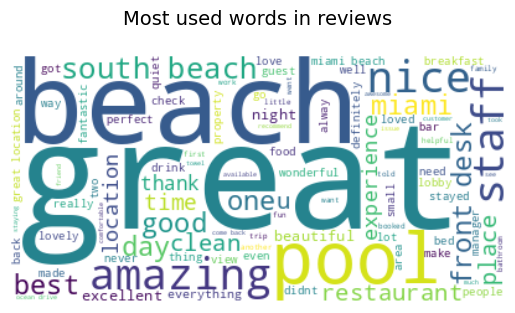

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["hotel", "room", "title", "service", "content", "stay"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most used words in reviews\n", fontsize=14)
plt.show()


### Length of review and Rating

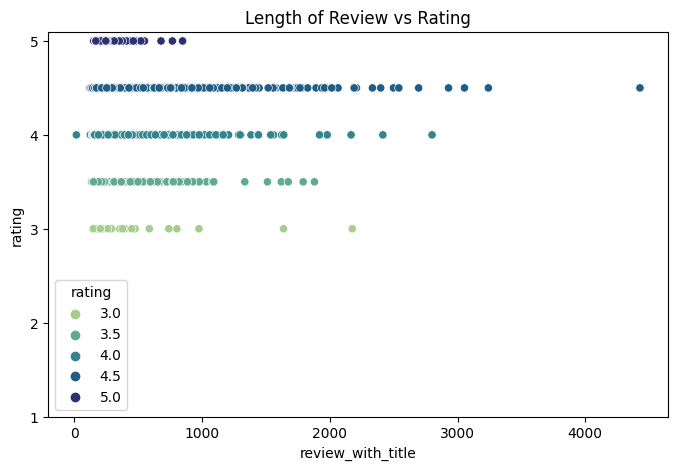

In [ ]:
#Checking the length of words in a review for all the rating
plt.figure(figsize=(8,5))
sns.scatterplot(x=miami_df['review_with_title'].apply(len), y=miami_df['rating'], data=miami_df, palette='crest', hue='rating')
plt.title('Length of Review vs Rating')
plt.yticks([1,2,3,4,5])
plt.show()

*   From above visual, we can say that the length of review has an effect on ratings.
*   Lower ratings have lower length of review compared to top ratings.

## Embedding the Miami data

In [ ]:
embedder = SentenceTransformer('all-mpnet-base-v2')

### GPU check

In [ ]:
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")
else:
  print("GPU Found!")
  embedder =  embedder.to('cuda')

GPU Found!


### Apply encoding and store as PKL file

In [ ]:
# startTime = time.time()

# miami_df["embedding"] = miami_df.review_with_title.apply(lambda x: embedder.encode(x))

# executionTime = (time.time() - startTime)
# print('Execution time in seconds: ' + str(executionTime))

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# miami_df.to_pickle('/content/drive/MyDrive/Build_LLM_from_Scratch/Miami_hotel_search/miami_data.pkl')

### Read Miami data from PKL file

In [ ]:
miami_df = pd.read_pickle('/content/drive/MyDrive/Build_LLM_from_Scratch/Miami_hotel_search/miami_data.pkl')

In [ ]:
miami_df.head(3)

,id,type,name,image,awards,rankingPosition,priceLevel,priceRange,category,rating,...,webUrl,website,rankingString,rankingDenominator,numberOfReviews,review,title,review_with_title,embedding,similarity
0,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,Hands down my absolute favorite hotel in South...,My favorite hotel in Miami--Petar is the best!,title favorite hotel miami petar best content ...,"[-0.0028501276, -0.0015026563, -0.012142392, -...",[0.5179081]
1,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,There are not enough words to explain the sump...,Exquisite Stay,title exquisite stay content enough word expla...,"[-0.0078192, 0.026787888, -0.022642579, 0.0598...",[0.29396126]
2,7787044,HOTEL,Faena Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],5,$$$$,"$729 - $1,426",hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.faena.com/miami-beach,#5 of 235 hotels in Miami Beach,235,2123,I went for the Burlesque show which was absolu...,Burlesqu Show,title burlesqu show content went burlesque sho...,"[0.013054229, 0.060819544, 0.016207822, -0.014...",[0.18999268]


## Search hotels in Miami by Reviews

In [ ]:
# search through the reviews for a specific product
def search_reviews(df, query, n=5, pprint=True):
    query_embedding = embedder.encode(query,show_progress_bar=True)
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, query_embedding.reshape(768,-1)))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n))

    return results

In [ ]:
query = 'close to south beach and great food nearby'

In [ ]:
results = search_reviews(miami_df,query,10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
results

,id,type,name,image,awards,rankingPosition,priceLevel,priceRange,category,rating,...,webUrl,website,rankingString,rankingDenominator,numberOfReviews,review,title,review_with_title,embedding,similarity
2142,85101,HOTEL,Catalina Hotel & Beach Club,https://media-cdn.tripadvisor.com/media/photo-...,[],59,$$,$121 - $231,hotel,3.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,http://catalinahotel.com/,#59 of 235 hotels in Miami Beach,235,5852,Good location and service. The hotel has two p...,Great location and service,title great location service content good loca...,"[0.012938884, 0.00545358, 0.0044888146, 0.0078...",[0.7107144]
2146,256986,HOTEL,Loews Miami Beach Hotel,https://media-cdn.tripadvisor.com/media/photo-...,[],57,$$$$,$329 - $616,hotel,4.0,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.loewshotels.com/miami-beach,#57 of 235 hotels in Miami Beach,235,10276,A physically beautiful hotel in every way. Cat...,Best Stay in South Beach,title best stay south beach content physically...,"[0.013695814, -0.04714131, 0.010081696, 0.0111...",[0.7100609]
2424,85177,HOTEL,Fontainebleau Miami Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],106,$$$$,$314 - $562,hotel,4.0,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://fontainebleau.com/,#106 of 235 hotels in Miami Beach,235,19456,I stayed in two different units back-to-back (...,Great offerings directly beachfront!,title great offering directly beachfront conte...,"[0.013064336, 0.011132223, 0.0017330485, -0.02...",[0.69407845]
2327,87000,HOTEL,Uma House by Yurbban,https://media-cdn.tripadvisor.com/media/photo-...,[],16,$$$,$194 - $328,hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.umahousesouthbeach.com/?utm_source...,#16 of 235 hotels in Miami Beach,235,2141,I had zero issue with this hotel. The location...,Chic Just Like South Beach,title chic like south beach content zero issue...,"[0.016268715, 0.030710286, 0.019285021, -0.012...",[0.69308865]
1716,1161109,HOTEL,W South Beach,https://media-cdn.tripadvisor.com/media/photo-...,[],19,$$$$,"$664 - $1,146",hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.marriott.com/en-us/hotels/miaws-w-...,#19 of 235 hotels in Miami Beach,235,5045,Every time I come to South Beach I have to go ...,Best beach on South Beach Miami,title best beach south beach miami content eve...,"[-0.021578452, -0.008657336, 0.0013350126, 0.0...",[0.68741417]
1380,240165,HOTEL,Sagamore Hotel,https://media-cdn.tripadvisor.com/media/photo-...,[],107,$$$$,$243 - $447,hotel,4.0,...,https://www.tripadvisor.com/Hotel_Review-g3443...,https://www.sagamoresouthbeach.com/,#107 of 235 hotels in Miami Beach,235,2933,Highly recommend this place This is my 2nd tim...,My new favorite place in south Beach ⛱️,title new favorite place south beach content h...,"[-0.009212356, 0.005560557, 0.0092892805, -0.0...",[0.6773648]
659,3819950,HOTEL,Posh South Beach Hostel,https://media-cdn.tripadvisor.com/media/photo-...,[],1,$,$43 - $104,hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,http://www.poshsouthbeach.com,#1 of 206 Specialty lodging in Miami Beach,206,868,It is not my first time at posh south beach…ev...,the best place to stay in south beach,title best place stay south beach content firs...,"[-0.017806599, -0.03560155, 0.013033849, -0.01...",[0.6705365]
277,115192,HOTEL,Pelican Hotel,https://media-cdn.tripadvisor.com/media/photo-...,[],51,$$$$,$265 - $454,hotel,4.5,...,https://www.tripadvisor.com/Hotel_Review-g3443...,http://www.pelicanhotel.com/,#51 of 235 hotels in Miami Beach,235,1429,Excellent style and decor; fabulous staff. Ro...,Gem in the heart of South Beach.,title gem heart south beach content excellent ...,"[0.018441068, 0.016793156, -0.0054264325, 0.05...",[0.6700667]
1084,15346944,HOTEL,"Life House, South of Fifth",https://media-cdn.tripadvisor.com/media/photo-...,[],158,$$$,$194 - $397,hotel,4.0,...,https://www.tripadvisor.com/Hotel_Review-g3443...,ht

## Take all reviews and group by Hotel name

In [ ]:
def search(query):
  n = 15
  query_embedding = embedder.encode(query)
  miami_df["similarity"] = miami_df.embedding.apply(lambda x: cosine_similarity(x, query_embedding.reshape(768,-1)))

  results = (
      miami_df.sort_values("similarity", ascending=False)
      .head(n))

  resultlist = []

  hlist = []
  for r in results.index:
      if results.name[r] not in hlist:
          smalldf = results.loc[results.name == results.name[r]]
          if smalldf.shape[1] > 3:
            smalldf = smalldf[:3]

          resultlist.append(
          {
            "name":results.name[r],
            "score": smalldf.similarity[r][0],
            "rating": smalldf.rating.max(),
            "relevant_reviews": [ smalldf.review[s] for s in smalldf.index]
          })
          hlist.append(results.name[r])
  return resultlist

In [ ]:
search('near South beach')

[{'name': 'W South Beach',
  'score': 0.6490246,
  'rating': 4.5,
  'relevant_reviews': ['Every time I come to South Beach I have to go to the W hotel on Collins. Their pool and beach area are amazing! The pool has nice cabanas but I prefer the sand so I go to Filip on the beach. He always takes care of me every time I come!']},
 {'name': 'Uma House by Yurbban',
  'score': 0.61165416,
  'rating': 4.5,
  'relevant_reviews': ['I had zero issue with this hotel. The location was perfect. Short walk to Ocean Drive and South Beach and to Lincoln Rd Mall. The resort fee included beach chairs, pool/beach towels, complimentary wine hour, wifi, amongst other amenities. The hotel was nicely decorated and looked and smelled very clean. The staff was very friendly from check in to check out. \n\nWould absolutely stay here again!']},
 {'name': 'Suites on South Beach',
  'score': 0.5949285,
  'rating': 4.0,
  'relevant_reviews': ['It has been our place to stay in South Beach before and after the pand

In [ ]:
search('beach view with restaurant')

[{'name': 'Fontainebleau Miami Beach',
  'score': 0.7057247,
  'rating': 4.0,
  'relevant_reviews': ["I stayed in two different units back-to-back (extended my stay at the last minute), both in the Tresor tower, which is separate from the main building where the restaurants, shops, and spa are located but easily accessed through connecting walkways.  Both units were as expected: clean, comfortable, and fully functional, with private balconies.  The first was overlooking pools and ocean--spectacular!   The pools and other common areas never felt too crowded though if you want an umbrella as well as a chair you shouldn't come too late.  Food and drink service at pools and beach was excellent.  The beach is gorgeous.  Note that while TVs have basic channels, after many calls I finally learned it's impossible to get anything On Demand or to connect to Netflix etc.  I didn't eat in the restaurants other than the pool bar so I can't comment on that, but there are plenty of good restaurants i